In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

D:\toolkits.win\Anaconda3-2021.05\envs\tf-cpu-1.13\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\toolkits.win\Anaconda3-2021.05\envs\tf-cpu-1.13\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\toolkits.win\Anaconda3-2021.05\envs\tf-cpu-1.13\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\toolkits.win\Anaconda3-20

In [2]:
def get_stock_data(filename='../dataset/Stk.0941.HK.all.csv'):
    df = pd.read_csv(filename)
    cols = list(df)
    #print(cols)
    tmp=filename.index('Stk')
    #print(tmp)
    tmp+=len('Stk.')
    tmpstr=filename[tmp:tmp+len('0941.HK.')]+'Adjusted'
    tmpstr_close=filename[tmp:tmp+len('0941.HK.')]+'Close'
    cols.insert(5, cols.pop(cols.index(tmpstr)))
    cols.insert(1, cols.pop(cols.index(tmpstr_close)))
    #print(cols)
    #print(cols[0:2])
    df = df.loc[:, cols]
    df_all = df
    ###
    df = df.loc[:, cols[0:2]]
    df_all = df_all.loc[:, cols[0:2]]
    #print(df.iloc[0:1481,0])
    num_train = 1480
    df = df.iloc[0:num_train]
    #print(df)
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
    date_all_ori = pd.to_datetime(df_all.iloc[:, 0]).tolist()
    #print(min(df.iloc[:, 4]))
    #print(max(df.iloc[:, 4]))
    #print(df.head())
    df.head()
    
    return df, df_all, date_ori, date_all_ori, num_train

In [3]:
def data_norm(df, df_all):
    allmean = [np.mean(df.iloc[:, i+1]).astype('float32') for i in range(df.shape[1]-1)]
    allstd  = [np.std(df.iloc[:, i+1]).astype('float32') for i in range(df.shape[1]-1)]
    #print(allmean)
    #print(allstd)
    #print(allmean[0])
    #print(allstd[0])
    df_log = [(df.iloc[:, i+1].astype('float32')-np.mean(df.iloc[:, i+1]).astype('float32'))/np.std(df.iloc[:, i+1]).astype('float32') for i in range(df.shape[1]-1)]
    #minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
    #df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
    df_log = pd.DataFrame(df_log)
    df_log = pd.DataFrame(df_log.values.T, index=df_log.columns, columns=df_log.index)
    #print(df_log.head())
    #print(df_log.shape[0])
    #print(df_log.iloc[0,0])
    #
    df_all_log = [(df_all.iloc[:, i+1].astype('float32')-np.mean(df.iloc[:, i+1]).astype('float32'))/np.std(df.iloc[:, i+1]).astype('float32') for i in range(df.shape[1]-1)]
    #minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
    #df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
    df_all_log = pd.DataFrame(df_all_log)
    df_all_log = pd.DataFrame(df_all_log.values.T, index=df_all_log.columns, columns=df_all_log.index)
    #print(df_all_log.head())
    #print(df_all_log.shape[0])
    #print(df_all_log.iloc[0,0])
    
    return df_log, df_all_log

In [4]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [5]:
def model_init_paras(num_layers, df_log, size_layer, dropout_rate):
    tf.reset_default_graph()
    modelnn = Model(
        0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    return modelnn, sess

In [6]:
def model_train(modelnn, sess, epoch, num_layers, df_log, size_layer, timestamp):
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss = 0
        for k in range(0, df_log.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_log.shape[0] -1)
            batch_x = np.expand_dims(
                df_log.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_log.iloc[k + 1 : index + 1, :].values
            last_state, _, loss = sess.run(
                [modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss += loss
        total_loss /= df_log.shape[0] // timestamp
        if (i + 1) % 10 == 0:
            print('epoch:', i + 1, 'avg loss:', total_loss)
    
    return modelnn

In [7]:
def model_predict(modelnn, sess, df_all_log, date_all_ori, future_day, timestamp, num_layers, size_layer):
    df_log = df_all_log
    date_ori = date_all_ori
    #print(df_log.shape[0])
    output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
    output_predict[0] = df_log.iloc[0]
    #print(output_predict[0])
    #print(output_predict.shape[0])
    upper_b = ((df_log.shape[0] - 1) // timestamp) * timestamp
    #print(upper_b)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for k in range(0, ((df_log.shape[0] - 1) // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_log.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    return output_predict, upper_b, df_log, date_ori, init_value

In [8]:
def model_predict_more(modelnn, sess, output_predict, upper_b, df_log, date_ori, init_value):
    #print(output_predict[upper_b + 1 : df_log.shape[0] + 1])
    for i in range(future_day - 1):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[df_log.shape[0]] = out_logits[-1]
        df_log.loc[df_log.shape[0]] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
        
    return df_log, date_ori, output_predict

In [9]:
def denorm_data(df_log, date_ori, output_predict):
    #print(df_log.iloc[-timestamp:])
    df_log = [output_predict[:, i].astype('float32')*np.std(df.iloc[:, i+1]).astype('float32')+np.mean(df.iloc[:, i+1]).astype('float32') for i in range(df.shape[1]-1)]
    df_log = pd.DataFrame(df_log)
    df_log = pd.DataFrame(df_log.values.T, index=df_log.columns, columns=df_log.index)
    df_log_norm = [output_predict[:, i].astype('float32') for i in range(df.shape[1]-1)]
    df_log_norm = pd.DataFrame(df_log_norm)
    df_log_norm = pd.DataFrame(df_log_norm.values.T, index=df_log_norm.columns, columns=df_log_norm.index)
    #print(df_log)
    #df_log = minmax.inverse_transform(output_predict)
    date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
    
    return df_log, df_log_norm, date_ori

In [10]:
def swap_data(df, df_all):
    df_train = df
    df = df_all
    #print(df_log.shape[0])
    return df_train, df

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [11]:
def plot_combined(df, df_log):
    numcols=len(list(df))
    current_palette = sns.color_palette('Paired', 2*numcols)
    fig = plt.figure(figsize = (15, 10))
    ax = plt.subplot(111)
    x_range_original = np.arange(df.shape[0])
    x_range_future = np.arange(df_log.shape[0])
    ncol = numcols-1
    if ncol > 1:
        ncol -= 1
    for ind in range(ncol):
        ind2=ind+1
        ax.plot(
            x_range_original,
            df.iloc[:, ind2],
            label = 'true '+'%d'%ind2,
            color = current_palette[ind*2],
        )
        ax.plot(
            x_range_future,
            anchor(df_log.iloc[:, ind], 0.5),
            label = 'predict '+'%d'%ind,
            color = current_palette[ind*2+1],
        )
    box = ax.get_position()
    ax.set_position(
        [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
    )
    ax.legend(
        loc = 'upper center',
        bbox_to_anchor = (0.5, -0.05),
        fancybox = True,
        shadow = True,
        ncol = 5,
    )
    plt.title('overlap stock market')
    #plt.xticks(x_range_future[::30], date_ori[::30])
    plt.show()

In [12]:
def plot_separated(df, df_log):
    numcols=len(list(df))
    current_palette = sns.color_palette('Paired', 2*numcols)
    fig = plt.figure(figsize = (20, 8))
    x_range_original = np.arange(df.shape[0])
    x_range_future = np.arange(df_log.shape[0])
    plt.subplot(1, 2, 1)
    ncol = numcols-1
    if ncol > 1:
        ncol -= 1
    for ind in range(ncol):
        ind2=ind+1
        plt.plot(
            x_range_original,
            df.iloc[:, ind2],
            label = 'true '+'%d'%ind2,
            color = current_palette[ind*2],
        )
    #plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
    plt.legend()
    plt.title('true market')
    plt.subplot(1, 2, 2)
    for ind in range(ncol):
        plt.plot(
            x_range_future,
            anchor(df_log.iloc[:, ind], 0.5),
            label = 'predict '+'%d'%ind,
            color = current_palette[ind*2+1],
        )
    #plt.xticks(x_range_future[::60], date_ori[::60])
    plt.legend()
    plt.title('predict market')
    plt.show()

In [13]:
def plot_volume_combined(df, df_log):
    fig = plt.figure(figsize = (15, 10))
    ax = plt.subplot(111)
    x_range_original = np.arange(df.shape[0])
    x_range_future = np.arange(df_log.shape[0])
    ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
    ax.plot(x_range_future, anchor(df_log.iloc[:, -1], 0.5), label = 'predict Volume')
    box = ax.get_position()
    ax.set_position(
        [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
    )
    ax.legend(
        loc = 'upper center',
        bbox_to_anchor = (0.5, -0.05),
        fancybox = True,
        shadow = True,
        ncol = 5,
    )
    #plt.xticks(x_range_future[::30], date_ori[::30])
    plt.title('overlap market volume')
    plt.show()

In [14]:
def plot_volume_separated(df, df_log):
    fig = plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    x_range_original = np.arange(df.shape[0])
    x_range_future = np.arange(df_log.shape[0])
    plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
    #plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
    plt.legend()
    plt.title('true market volume')
    plt.subplot(1, 2, 2)
    plt.plot(x_range_future, anchor(df_log.iloc[:, -1], 0.5), label = 'predict Volume')
    #plt.xticks(x_range_future[::60], date_ori[::60])
    plt.legend()
    plt.title('predict market volume')
    plt.show()

In [15]:
def calculateRMSE(X,Y): 
  return (np.linalg.norm(X-Y, ord=2)/len(Y))**0.5


In [16]:
def get_error_val_train(df, df_log, num_train):
    tmp = calculateRMSE(df.iloc[0:num_train, 0],df_log.iloc[0:num_train, 0])
    #print(tmp)
    return tmp


In [17]:
def get_error_val_test(df, df_log, num_train):
    num_all = df.shape[0]
    tmp = calculateRMSE(df.iloc[num_train:num_all, 0],df_log.iloc[num_train:num_all, 0])
    #print(tmp)
    return tmp


In [18]:
num_run = 10
num_layers = 1
size_layer = 10
timestamp = 1
epoch = 200
dropout_rate = 0.7
future_day = 50


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
epoch: 10 avg loss: 0.06594197206461988
epoch: 20 avg loss: 0.06158576219416769
epoch: 30 avg loss: 0.0643221130412121
epoch: 40 avg loss: 0.0551460581744915

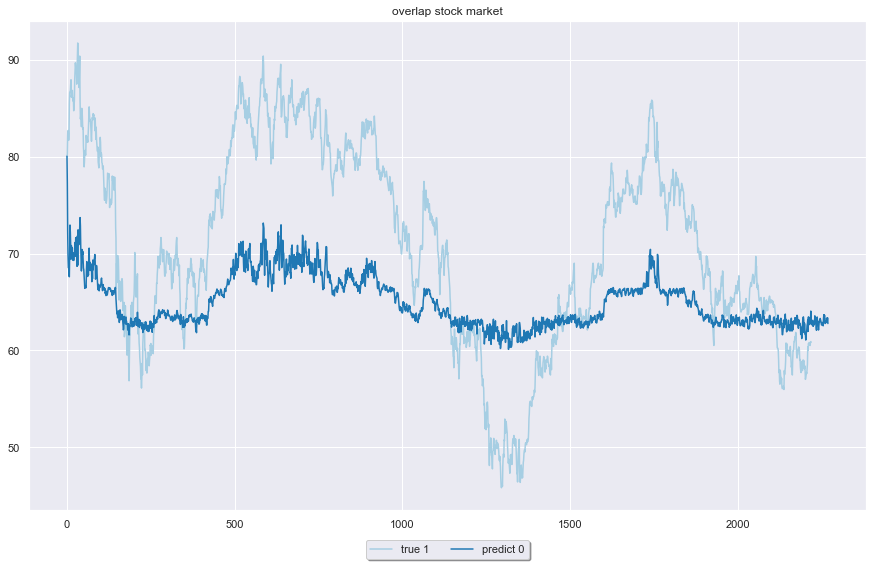

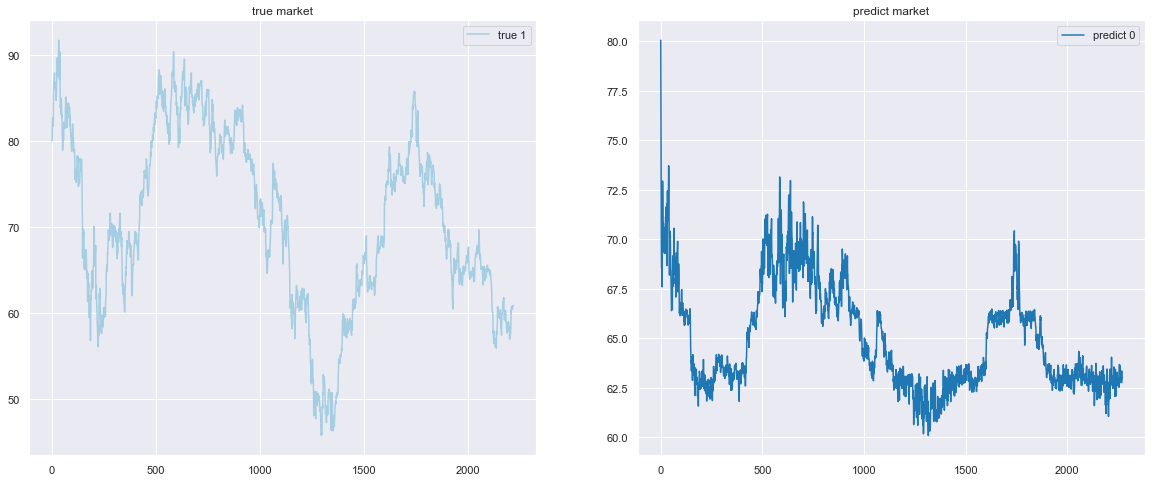

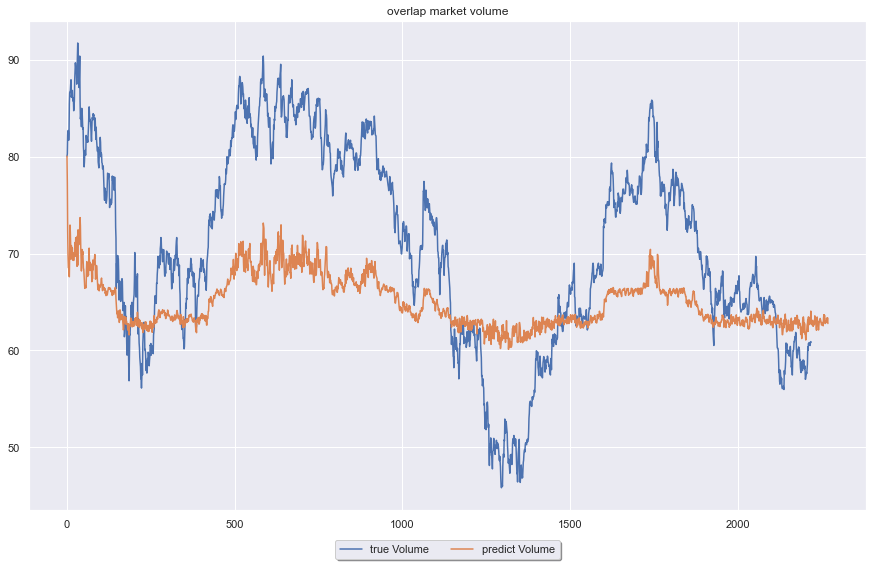

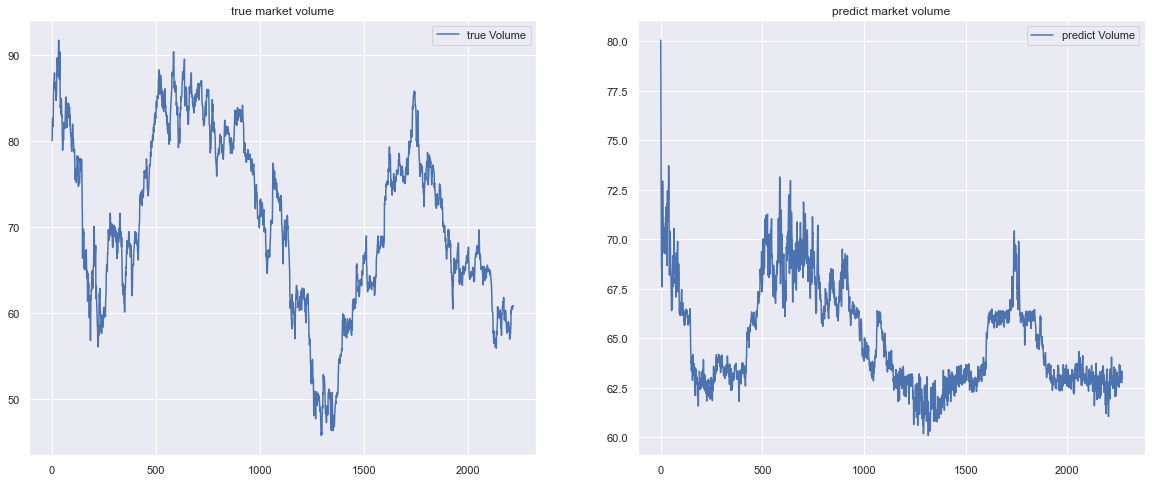

epoch: 10 avg loss: 0.0748442488891475
epoch: 20 avg loss: 0.06454701542800813
epoch: 30 avg loss: 0.06879162868640111
epoch: 40 avg loss: 0.06468674199312138
epoch: 50 avg loss: 0.14945460740654873
epoch: 60 avg loss: 0.10168320222920549
epoch: 70 avg loss: 0.09445680284796451
epoch: 80 avg loss: 0.09362255227646005
epoch: 90 avg loss: 0.10446079077648888


In [ ]:
filename='../dataset/Stk.0005.HK.all.csv'

all_error_train = []
all_error_test  = []

for _ in range(num_run):
    df, df_all, date_ori, date_all_ori, num_train = get_stock_data(filename)
    df_log, df_all_log = data_norm(df, df_all)
    modelnn, sess = model_init_paras(num_layers, df_log, size_layer, dropout_rate)
    modelnn = model_train(modelnn, sess, epoch, num_layers, df_log, size_layer, timestamp)
    output_predict, upper_b, df_log, date_ori, init_value = model_predict(modelnn, sess, df_all_log, date_all_ori, future_day, timestamp, num_layers, size_layer)
    df_log, date_ori, output_predict = model_predict_more(modelnn, sess, output_predict, upper_b, df_log, date_ori, init_value)
    df_log, df_log_norm, date_ori = denorm_data(df_log, date_ori, output_predict)
    df_train, df = swap_data(df, df_all)
    plot_combined(df, df_log)
    plot_separated(df, df_log)
    plot_volume_combined(df, df_log)
    plot_volume_separated(df, df_log)
    error_train = get_error_val_train(df_all_log, df_log_norm, num_train)
    error_test = get_error_val_test(df_all_log, df_log_norm, num_train)
    all_error_train.append(error_train)
    all_error_test.append(error_test)
    sess.close()

print('all train')
print(all_error_train)
print('all test')
print(all_error_test)
print('mean train')
print(np.mean(all_error_train))
print('mean test')
print(np.mean(all_error_test))

In [ ]:
print('all train')
print(all_error_train)
print('all test')
print(all_error_test)
print('mean train')
print(np.mean(all_error_train))
print('mean test')
print(np.mean(all_error_test))

In [ ]:
all train
[0.16701314942175202, 0.16477593954178937, 0.16819178749391983, 0.15226190426971709, 0.17445873016402424, 0.17476232853799464, 0.14570130943245696, 0.16051021799610088, 0.15873864462461523, 0.15328677540722277]
all test
[0.15458669340210798, 0.15301257324069548, 0.15407804187500193, 0.1401759507243471, 0.1646049754387234, 0.16081217640342974, 0.13976356019533392, 0.14754331490633044, 0.14486775115077513, 0.14474822453112093]
mean train
0.1619700786889593
mean test
0.1504193261867866